# Project 3 - Life Pro Tips vs. Unethical Life Pro Tips Classification
**Author:** Jocelyn Lutes

## Problem Statement

## Executive Summary

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
import nltk
from nltk.corpus import stopwords
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve

RANDOM_STATE = 42

## Read-In Data

In [2]:
subreddits = pd.read_csv('../data/subreddits.csv')

In [3]:
subreddits.head(2)

,Unnamed: 0,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,0,LPT: Answers to why,[removed],LifeProTips,1595040153,AlienAgency,2,1,True,2020-07-17
1,1,¿Quieres obtener juegos y premios gratis en tu...,[removed],LifeProTips,1595040616,GarbageMiserable0x0,2,1,True,2020-07-17


## Data Cleaning

### Drop Unnecessary Columns

#### Drop 'Unnamed: 0'

In [4]:
subreddits.drop(columns = 'Unnamed: 0', inplace = True)

#### Drop 'created_utc' column and 'is_self' columns

In [5]:
subreddits.drop(columns = ['created_utc', 'is_self'], inplace = True)

### Clean Title Column

#### Remove 'UPLT Requests' 

In [6]:
for index, title in enumerate(subreddits['title']):
    if 'ulpt request' in title.lower():
        subreddits.drop(index, inplace = True)

#### Remove 'LPT' and ULPT' from title

In [7]:
for title in subreddits['title']:
    if 'LPT'.lower() in title.lower() or 'ULPT'.lower() in title.lower():
        subreddits['title'] = subreddits['title'].str.replace('ULPT', '')
        subreddits['title'] = subreddits['title'].str.replace('LPT', '')

In [8]:
for post in subreddits['title']:
    if '&amp;' in post.lower():
        subreddits['title'] = subreddits['title'].str.replace('&amp;', '')

### Clean 'SelfText' Column

In [9]:
subreddits['selftext'].fillna('', inplace = True)
subreddits['selftext'] = subreddits['selftext'].str.replace('\[removed\]', '')
subreddits['selftext'] = subreddits['selftext'].str.replace('\[\]', '')

In [10]:
len(subreddits[subreddits['selftext']=='']['selftext'])/len(subreddits['selftext'])

0.6529291553133515

In [11]:
subreddits[subreddits['selftext']=='']['subreddit'].value_counts(normalize = True)

UnethicalLifeProTips    0.568336
LifeProTips             0.431664
Name: subreddit, dtype: float64

In [12]:
for post in subreddits['selftext']:
    subreddits['selftext'] = subreddits['selftext'].str.replace('x200B', '')

In [13]:
for post in subreddits['selftext']:
    if '&amp;' in post.lower():
        subreddits['selftext'] = subreddits['selftext'].str.replace('&amp;', '')

### Clean 'Num_Comments' Column

In [14]:
subreddits['num_comments'].isna().sum()

0

In [15]:
subreddits['num_comments'].describe()

count    5872.000000
mean       16.246935
std       125.518164
min         0.000000
25%         1.000000
50%         2.000000
75%         6.000000
max      5091.000000
Name: num_comments, dtype: float64

Within this dataset, 75% of posts have 6 or fewer comments. Only 146 posts have 100 or more comments, and only 8 posts have 1000 or more comments. Because the posts with more comments could be exclusively featured in one subreddit or the other, I will not drop any rows, even if they seem like outliers.

### Clean 'Score' Column

In [16]:
subreddits['score'].isna().sum()

0

In [17]:
subreddits['score'].describe()

count     5872.000000
mean        32.774183
std        606.188675
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max      28606.000000
Name: score, dtype: float64

As shown above, 75% of all posts in this data set have a score of 1 or below. Only 81 posts have a score of 100 or more, and only 25 posts have a score of 1000 or higher. Because the high scores could be characteristic of one subreddit, I will not drop any rows based on score. 

### Clean 'Timestamp' Column

In [18]:
subreddits['timestamp'].isna().sum()

0

In [19]:
subreddits['timestamp'].describe()

count           5872
unique           132
top       2020-07-04
freq             219
Name: timestamp, dtype: object

The timestamp data looks okay.

### Clean 'Author' Column

EDA revealed that one user 'h3xadecimal2' has posted the same spam post to both subreddits. These posts will not contribute meaningful data to our model, so the posts by this user will be dropped from the data frame.

In [20]:
subreddits = subreddits[subreddits['author']!='h3xadecimal2']

There were also three posts by authors of multiple posts that had the same text, so one of the posts will be dropped.

In [21]:
subreddits.drop(117, inplace = True)

In [22]:
subreddits.drop(569, inplace = True)

In [23]:
subreddits.drop(2145, inplace = True)

## Basic Feature Engineering

Upon looking at the data, there are some features that I know that I would like to create to without exploring the data. I will create these features here. 

### Engineer a Total Text Column

Some of the subreddits only have titles and no self text. However, these posts still provide a life pro tip. In order to get rid of the null values in the self text column while still preserving the entire post, I will combine the text columns.

In [24]:
subreddits['total_text'] = subreddits['title'] + subreddits['selftext']

In [25]:
subreddits.drop(columns = ['title', 'selftext'], inplace = True)

### Engineer a Post Length (Characters) Feature

In [26]:
subreddits['post_length_char'] = subreddits['total_text'].map(len)

### Engineer a Post Length (Word Count) Feature

In [27]:
subreddits['post_length_words'] = subreddits['total_text'].map(lambda x: len(x.split()))

### Convert Target to Binary Variable

In [28]:
subreddits['is_unethical'] = subreddits['subreddit'].map({'LifeProTips': 0, 'UnethicalLifeProTips': 1 })

In [29]:
subreddits['is_unethical'].value_counts(normalize = True)

1    0.544168
0    0.455832
Name: is_unethical, dtype: float64

## Export Clean Data

In [30]:
subreddits.to_csv('../data/subreddits_clean.csv')

## Text Preprocessing

In [31]:
subreddits = pd.read_csv('../data/subreddits_clean.csv')

subreddits.drop(columns = 'Unnamed: 0', inplace = True)

### Expanding Contractions

In [32]:
contractions = {
    "aren't": 'are not',
    "can't": 'cannot',
    "couldn't": "could not",
    "didn't": "did not",
    "doesnt": "does not",
    "don't": "do not",
    "hadn't": "had not", 
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "i'd": "i would",
    "i'll": "i will",
    "i am": "i'm",
    "i've": "i have",
    "isn't": "is not",
    "it's": "it is",
    "let's": "let us",
    "she'd":"she would",
    "she'll": "she will",
    "she's": "she is",
    "shouldn't":"should not",
    "there's": "there is",
    "they'd": "they had",
    "they'll":"they will",
    "they're": "they are", 
    "they've": "they have",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have", 
    "weren't": "were not",
    "what's": "what is",
    "where's": "where is",
    "who'd": "who would",
    "who'll": "who will",
    "who's": "who is",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are",
    "you've": "you have"
}

In [33]:
contraction_indices = []

for index, post in enumerate(subreddits['total_text']):
    for word in post.split():
        if word.lower() in contractions.keys(): # Check if word is a contraction
            contraction_indices.append((index, word)) # Add the index and contraction to a list

for entry in contraction_indices:
    subreddits.loc[entry[0], 'total_text'] = subreddits.loc[entry[0], 'total_text'].replace(entry[1].lower(), contractions[entry[1].lower()])

### Stem Words

**Note:** In order to decide between lemmatization and stemming, I created Logistic Regression models to see which seemed to perform best. Models with stemmed text had highest accuracy in those models.

In [34]:
# Create Tokens for Stemming

post_tokens = []

for post in subreddits['total_text']:
    post_tokens.append(word_tokenize(post.lower()))

In [35]:
# Stem Words and Convert Back to String

p_stemmer = PorterStemmer()

post_stemmer_tokens = []

for token in post_tokens:
    running_stemmer_tokens = []
    for word in token:
        running_stemmer_tokens.append(p_stemmer.stem(word))
    post_stemmer_tokens.append(' '.join(running_stemmer_tokens))

subreddits['stemmer_text'] = post_stemmer_tokens

### Rename `total_text` column to `original_text`

In [36]:
subreddits.rename(columns = {'total_text':'original_text'}, inplace = True)

### Create a Sentiment Score for Posts 

[Text Blob](https://textblob.readthedocs.io/en/dev/) provides a sentiment analyzer. Scores range from -1 (Negative) to 1 (Positive).

In [37]:
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

subreddits['polarity'] = subreddits['original_text'].apply(get_polarity)

# https://towardsdatascience.com/having-fun-with-textblob-7e9eed783d3f

In [38]:
# Create sentiment categories

positive_mask = subreddits['polarity'] > 0
negative_mask = subreddits['polarity'] < 0
neutral_mask = subreddits['polarity'] == 0

subreddits.loc[positive_mask, 'sentiment_cat'] = 'Positive'
subreddits.loc[negative_mask, 'sentiment_cat'] = 'Negative'
subreddits.loc[neutral_mask, 'sentiment_cat'] = 'Neutral'

### Export Preprocessed Text Data to CSV

In [39]:
subreddits.to_csv('../data/subreddits_preprocessed.csv')

## Exploratory Data Analysis

In [40]:
subreddits = pd.read_csv('../data/subreddits_preprocessed.csv')
subreddits.drop(columns = 'Unnamed: 0', inplace = True)

### Set Palette for Visualizations

In [41]:
red = '#e63946'
cream = 'f1faee'
light_blue = '#a8dadc'
medium_blue = '#457b9d'
navy = '#1d3557'

### Functions

In [42]:
def set_labels(title, xlabel, ylabel, title_size = 16, axis_size = 13):
    plt.title(title, fontdict = {'fontsize':title_size}, pad = 10)
    plt.xlabel(xlabel, fontdict = {'fontsize': axis_size})
    plt.ylabel(ylabel, fontdict = {'fontsize':13});

In [43]:
def create_v_boxplot(df, feature, fig_size = (8,6)):
    plt.figure(figsize=fig_size)
    sns.boxplot(df[feature], orient = 'v')
    plt.tight_layout;

In [44]:
def create_hist(df, feature, num_bins=10):
    sns.distplot(df[feature], bins = num_bins, kde = False, hist_kws=dict(edgecolor="k", linewidth=2))

In [45]:
def create_bar_xticks(df, x_col, y_col, hue=None, color = medium_blue, plot_size = (10,6), lw = 1.5, x_tick_labels = None, palette = None):
    plt.figure(figsize=plot_size)
    ax = sns.barplot(x = x_col, y = y_col, data = df, hue = hue, color = color, linewidth = lw, edgecolor = 'black', palette = palette)
    ax.set_xticklabels(x_tick_labels)
    plt.tight_layout;

In [46]:
def get_frequent_words(df, words_df, feature, binary_num):
    
    # Generate Word Counts
    feature_var = df[df[feature] == binary_num]
    feature_word_counts = {}

    for column in words_df.columns:
        feature_word_counts[column] = feature_var[column].sum()

    feature_word_counts_df = pd.DataFrame(sorted(feature_word_counts.items(), key = lambda x: x[1], reverse = True), columns = ['Word', 'Count'])
    return feature_word_counts_df.sort_values('Count', ascending = False)

In [47]:
def plot_frequent_words(word_count_df, subreddit):
    plt.figure(figsize = (18, 6))
    sns.barplot(word_count_df['Word'][:25], word_count_df['Count'].sort_values(ascending = False)[:25], palette = 'Blues_r', edgecolor = 'black')
    plt.title(f'25 Most Commonly Used Words in {subreddit}', fontdict = {'fontsize':15}, pad = 12)
    plt.xlabel('Word', fontdict = {'fontsize':13}, labelpad = 10)
    plt.ylabel('Count', fontdict = {'fontsize':13}, labelpad = 10)
    plt.tight_layout;

### Exploration of Authors

In [48]:
lpt_authors = subreddits[subreddits['subreddit'] == 'LifeProTips']['author']
ulpt_authors = subreddits[subreddits['subreddit'] == 'UnethicalLifeProTips']['author']

#### What percentage of authors are unique?

In [49]:
lpt_authors.nunique()/len(lpt_authors)

0.7485970819304153

In [50]:
ulpt_authors.nunique()/len(ulpt_authors)

0.7806330303979944

The percentage of unique authors between the two subreddits is similar.

#### Do any authors appear in both subreddits?

In [51]:
lpt_authors_set = set(lpt_authors)
ulpt_authors_set = set(ulpt_authors)

In [52]:
authors_in_common = lpt_authors_set & ulpt_authors_set

In [53]:
print('Authors in Common:', len(authors_in_common)) # Intersection

Authors in Common: 17


There are 17 authors who have posted on both subreddits.

### Compare Distributions of Numerical Data Between Subreddits

In [54]:
life_pro_tips = subreddits[subreddits['subreddit'] == 'LifeProTips']
unethical_life_pro_tips = subreddits[subreddits['subreddit'] == 'UnethicalLifeProTips']

#### Number of Comments

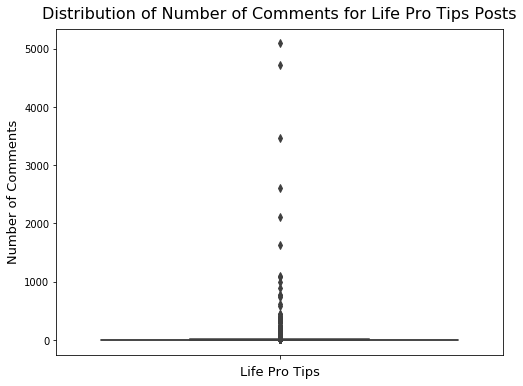

In [55]:
create_v_boxplot(life_pro_tips, 'num_comments')
set_labels('Distribution of Number of Comments for Life Pro Tips Posts', 'Life Pro Tips', 'Number of Comments');

As shown in the boxplot above, the range of number of comments for Life Pro Tips posts, is highly spread out. The minimum number of comments is 0, and the maximum number of comments is 5091. The interquartile range is from 2 comments to 8 comments. Only 653 out of the 2678 posts have more than 8 comments. These 653 posts appear as outliers in the boxplot. However, because posts with more comments could be a distinguishing feature between the subreddits, all points outside of the interquartile range will be kept in the dataset.

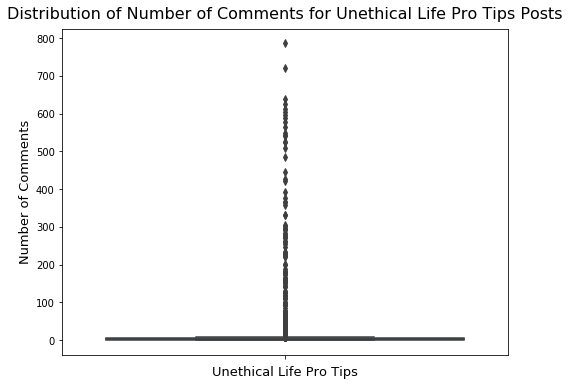

In [56]:
create_v_boxplot(unethical_life_pro_tips, 'num_comments')
set_labels('Distribution of Number of Comments for Unethical Life Pro Tips Posts', 'Unethical Life Pro Tips', 'Number of Comments');

Similar to the number of comments for Life Pro Tips Posts, we see that the range for number of comments for posts in Unethical Life Pro Tips is also highly spread out. The minimum number of comments is 0, and the maximum number of comments is 786. For Unethical Life Pro Tips, 75% of the posts have 4 or less comments. Only 791 out of 3194 comments have comment counts than 4, and many of these posts appear as outliers on the boxplot. However, again, because the variation in comments could be an important feature for distinguishing between the two subreddits, all posts will remain in the dataset.

#### Score

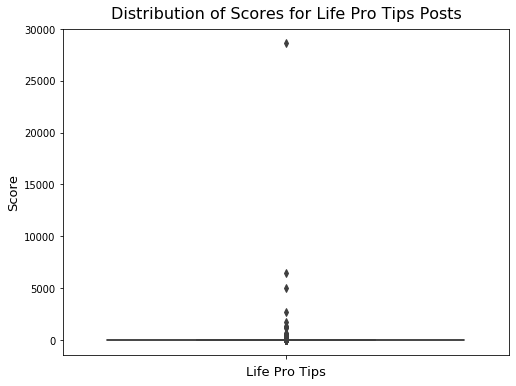

In [57]:
create_v_boxplot(life_pro_tips, 'score')
set_labels('Distribution of Scores for Life Pro Tips Posts', 'Life Pro Tips', 'Score');

Similar to the distributions for number of comments, the range of scores for Life Pro Tips posts is also highly variable. The range is from 0 to 28606, with 75% of posts having a score of 1 or less. Only 432 out of 2678 posts have a score higher than 1. Likely the posts with a high score became very popular and were featured on the main Reddit page. Again, because these high scores could hold important information, they will not be dropped.

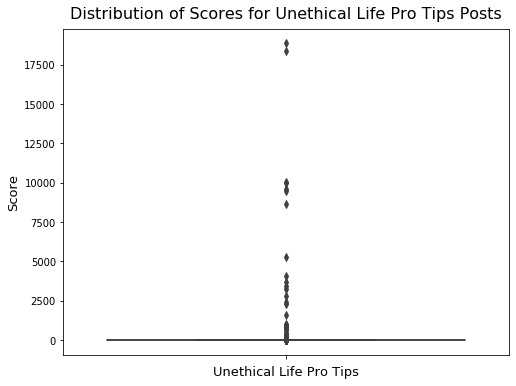

In [58]:
create_v_boxplot(unethical_life_pro_tips, 'score')
set_labels('Distribution of Scores for Unethical Life Pro Tips Posts', 'Unethical Life Pro Tips', 'Score');

The scores for Unethical Life Pro Tips are highly variable. The min score is 0, and the max score is 18,861. 75% of all posts have a score of 1 or less, so many posts appear as outliers on this figure.

#### Post Length (Characters)

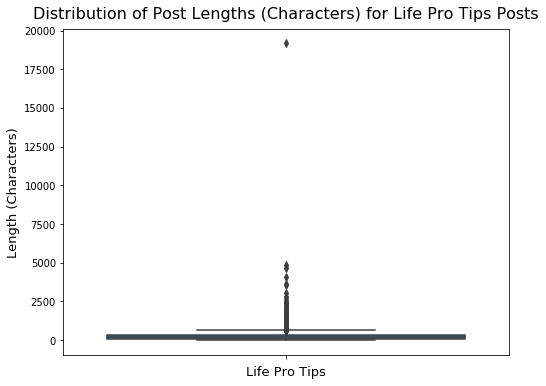

In [59]:
create_v_boxplot(life_pro_tips, 'post_length_char')
set_labels('Distribution of Post Lengths (Characters) for Life Pro Tips Posts', 'Life Pro Tips', 'Length (Characters)');

As shown in the boxplot above, there is a large range of post lengths in the dataset. The length in characters ranges from 1 character to 19164 characters, and 75% of all posts are 306.75 characters or less. Because the post with 19164 characters appears to be a guidebook, it will be dropped from the dataset. With the column dropped, the max length becomes 4856 characters.

In [60]:
# Drop column from original data set
subreddits.drop(308, inplace = True)

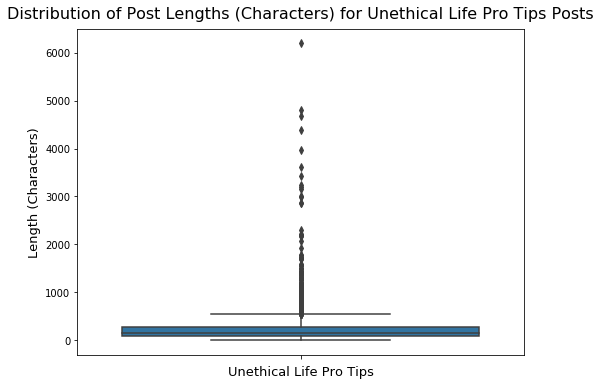

In [61]:
create_v_boxplot(unethical_life_pro_tips, 'post_length_char')
set_labels('Distribution of Post Lengths (Characters) for Unethical Life Pro Tips Posts', 'Unethical Life Pro Tips', 'Length (Characters)');

The range of lengths for posts in Unethical Life Pro Tips is also highly variable. The minimum post length is 2 characters, and the maximum is 6193 characters. 75% of posts are 266 characters or shorter. 

#### Post Length (Words)

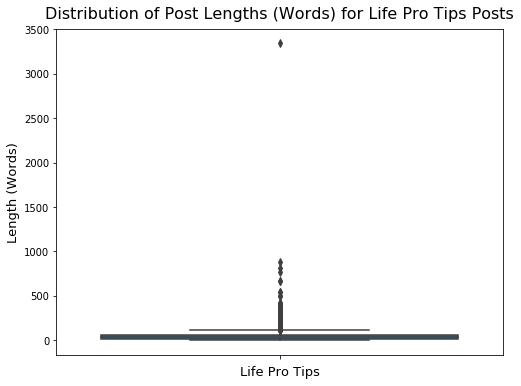

In [62]:
create_v_boxplot(life_pro_tips, 'post_length_words')
set_labels('Distribution of Post Lengths (Words) for Life Pro Tips Posts', 'Life Pro Tips', 'Length (Words)');

As shown above, there are still several posts whose lengths are considered outliers. The minimum length is 1 word, and the maximum length is 881 words. The median value is 29 words, and 75% of posts are 56 words or shorter.

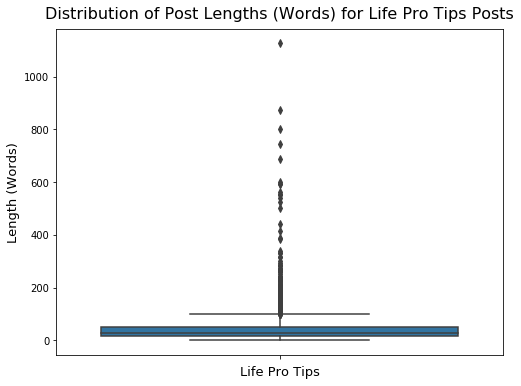

In [63]:
create_v_boxplot(unethical_life_pro_tips, 'post_length_words')
set_labels('Distribution of Post Lengths (Words) for Life Pro Tips Posts', 'Life Pro Tips', 'Length (Words)');

The range of variables for the word counts of Unethical Life Pro Tips posts is also large. The minimum value is 1, and the maximum value is 1125. The median length is 29, and 75% of posts are 48 words or fewer.

### Compare Average Post Lengths Between Subreddits

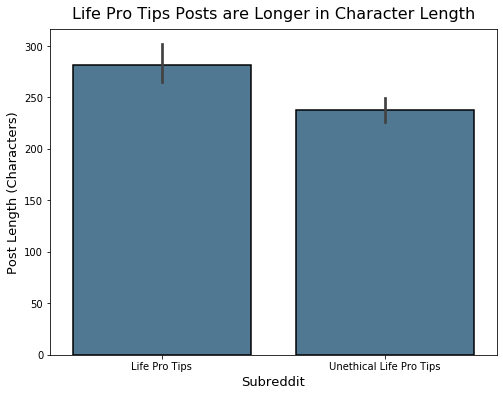

In [64]:
create_bar_xticks(df = subreddits,
                 x_col = 'subreddit',
                 y_col = 'post_length_char',
                 x_tick_labels = ['Life Pro Tips', 'Unethical Life Pro Tips'], plot_size = (8,6))
set_labels(title = 'Life Pro Tips Posts are Longer in Character Length', xlabel = 'Subreddit', ylabel = 'Post Length (Characters)')

The posts on Life Pro Tips are longer than the posts on Unethical Life Pro Tips. The mean character count for posts on Life Pro Tips is 274, while the mean character count for posts on Unethical Life Pro Tips is 238. It is important to note that the range of post lengths is big for Life Pro Tips, and this influences the mean.

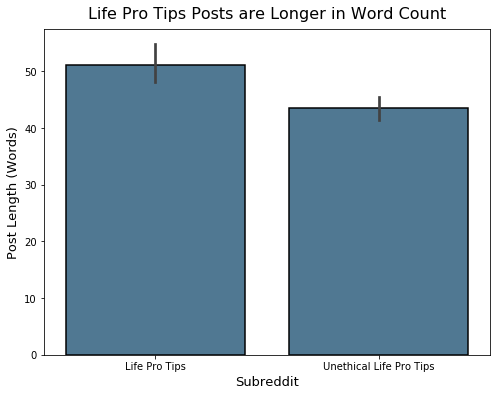

In [65]:
create_bar_xticks(df = subreddits,
                 x_col = 'subreddit',
                 y_col = 'post_length_words',
                 x_tick_labels = ['Life Pro Tips', 'Unethical Life Pro Tips'], plot_size = (8,6))
set_labels(title = 'Life Pro Tips Posts are Longer in Word Count', xlabel = 'Subreddit', ylabel = 'Post Length (Words)')

The posts on Life Pro Tips are longer than the posts on Unethical Life Pro Tips. The mean word count for posts on Life Pro Tips is 49.9 words, while the mean word count for posts on Unethical Life Pro Tips is 43.5 words. It is important to note that the range of post lengths is big for Life Pro Tips, and this influences the mean.

### Create 'Bag of Words' for EDA

In [66]:
# Original Text
og_corpus = subreddits['original_text']
og_cvec = CountVectorizer(stop_words = 'english', ngram_range = (1, 2), min_df = 5)
og_words = og_cvec.fit_transform(og_corpus)
og_words_df = pd.DataFrame(og_words.toarray(), columns = og_cvec.get_feature_names())
og_labeled_words_df = pd.concat([og_words_df, subreddits['is_unethical']], axis = 1)

In [67]:
# Stemmed Text
stemmed_corpus = subreddits['stemmer_text']
stemmed_cvec = CountVectorizer(stop_words = 'english', ngram_range = (1, 2), min_df = 5)
stemmed_words = stemmed_cvec.fit_transform(stemmed_corpus)
stemmed_words_df = pd.DataFrame(stemmed_words.toarray(), columns = stemmed_cvec.get_feature_names())
stemmed_labeled_words_df = pd.concat([stemmed_words_df, subreddits['is_unethical']], axis = 1)

### Plot Most Frequent Words By Subreddit

#### Original Text

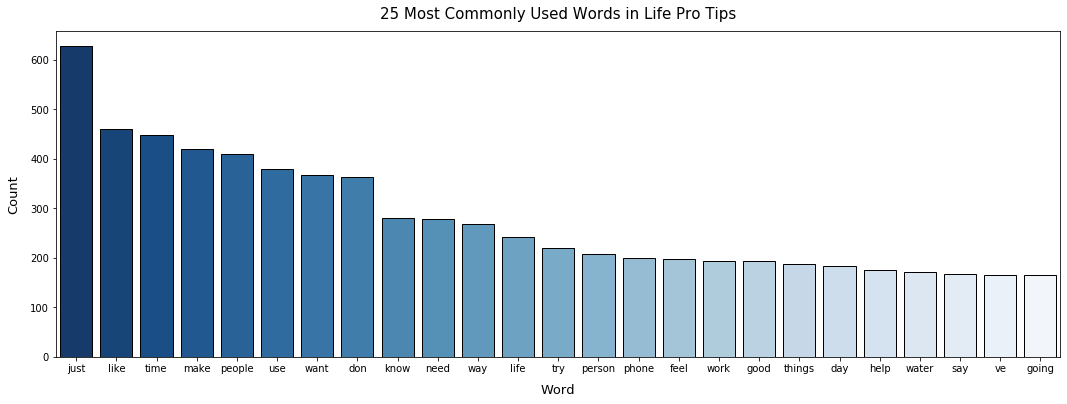

In [68]:
og_lpt_words_df = get_frequent_words(og_labeled_words_df, og_words_df, 'is_unethical', 0)
plot_frequent_words(og_lpt_words_df, 'Life Pro Tips')

The above figure shows the most common words in the Life Pro Tips Subreddit.

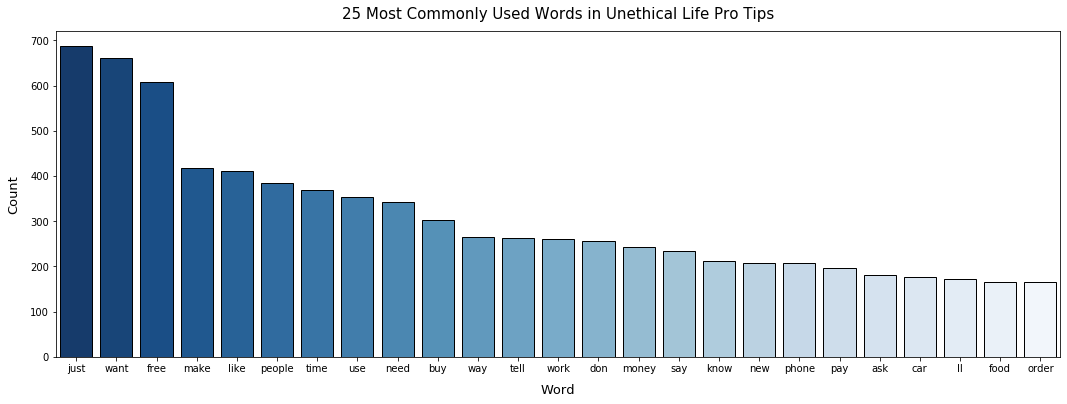

In [69]:
og_ulpt_words_df = get_frequent_words(og_labeled_words_df, og_words_df, 'is_unethical', 1)
plot_frequent_words(og_ulpt_words_df, 'Unethical Life Pro Tips')

The above figure shows the 25 most frequent worrds in the Unethical Life Pro Tips Subreddit.

##### Examine Overlap in Frequent Words

In [70]:
og_lpt_set = set(og_lpt_words_df.sort_values('Count', ascending = False)['Word'].tolist()[:25])
og_ulpt_set = set(og_ulpt_words_df.sort_values('Count', ascending = False)['Word'].tolist()[:25])

print('Words in Common:', og_lpt_set & og_ulpt_set) # Intersection
print()
print('Different Words:', og_lpt_set ^ og_ulpt_set) # Symmetric Difference

Words in Common: {'use', 'know', 'like', 'need', 'time', 'say', 'make', 'people', 'don', 'just', 'work', 'want', 'phone', 'way'}

Different Words: {'new', 'day', 'food', 'water', 'feel', 'things', 'person', 'buy', 'tell', 'free', 'help', 'money', 'car', 'good', 'pay', 'order', 'going', 'ask', 'll', 'life', 'try', 've'}


#### Stemmed Text with Stop Words Removed

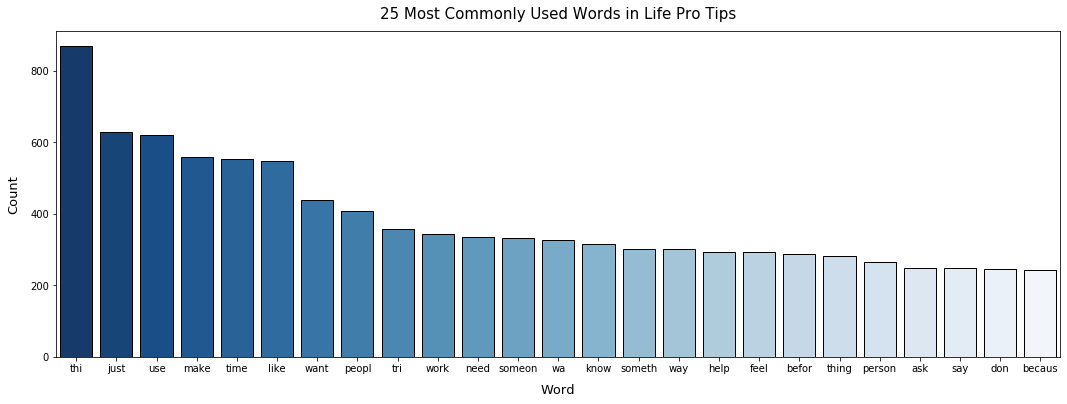

In [71]:
lpt_stemmed_words_df = get_frequent_words(stemmed_labeled_words_df, stemmed_words_df, 'is_unethical', 0)
plot_frequent_words(lpt_stemmed_words_df, 'Life Pro Tips')

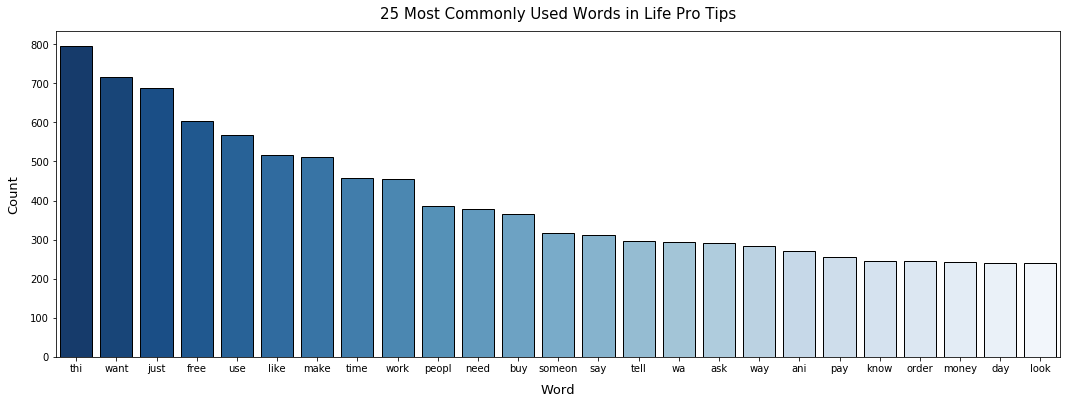

In [72]:
ulpt_stemmed_words_df = get_frequent_words(stemmed_labeled_words_df, stemmed_words_df, 'is_unethical', 1)
plot_frequent_words(ulpt_stemmed_words_df, 'Life Pro Tips')

In [73]:
stemmed_lpt_set = set(lpt_stemmed_words_df.sort_values('Count', ascending = False)['Word'][:25].tolist())
stemmed_ulpt_set = set(ulpt_stemmed_words_df.sort_values('Count', ascending = False)['Word'][:25].tolist())

print('Words in Common:', stemmed_lpt_set & stemmed_ulpt_set) # Intersection
print()
print('Different Words:', stemmed_lpt_set ^ stemmed_ulpt_set) # Symmetric Difference

Words in Common: {'ask', 'use', 'know', 'like', 'need', 'time', 'someon', 'say', 'make', 'peopl', 'just', 'work', 'want', 'thi', 'wa', 'way'}

Different Words: {'day', 'tri', 'feel', 'becaus', 'befor', 'person', 'buy', 'tell', 'free', 'help', 'money', 'thing', 'ani', 'pay', 'order', 'someth', 'don', 'look'}


### Analyze Sentiment of Posts
**Note:** Original Text from posts was used for sentiment analysis in order to not lose any emotional inflections.

#### Mean Polarity

##### Unethical Life Pro Tips

In [74]:
subreddits[subreddits['is_unethical']==0]['polarity'].mean()

0.07870080449383593

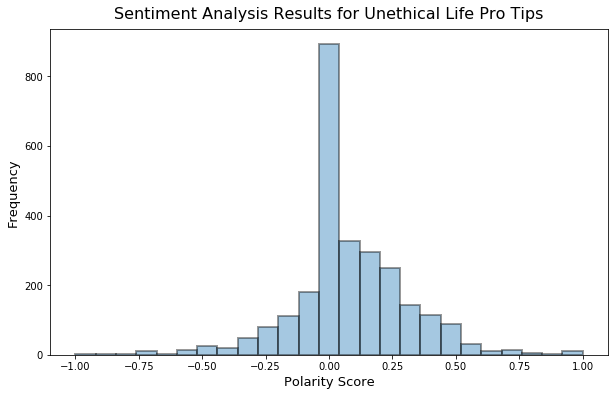

In [75]:
plt.figure(figsize = (10,6))
create_hist(subreddits[subreddits['is_unethical']==0],'polarity', num_bins = 25)
set_labels(title = 'Sentiment Analysis Results for Unethical Life Pro Tips', xlabel = 'Polarity Score', ylabel = 'Frequency', title_size = 16, axis_size = 13)

The majority of posts in the Unethical Life Pro Tips subreddit were determined to have a neutral tone.

##### Life Pro Tips

In [76]:
subreddits[subreddits['is_unethical']==1]['polarity'].mean()

0.06908249289934706

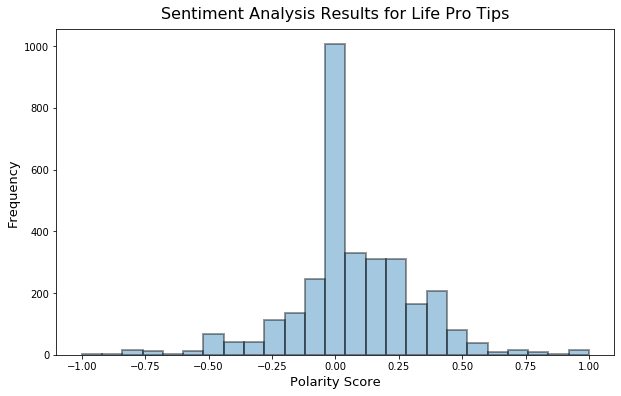

In [77]:
plt.figure(figsize=(10,6))
create_hist(subreddits[subreddits['is_unethical']==1],'polarity', num_bins = 25)
set_labels(title = 'Sentiment Analysis Results for Life Pro Tips', xlabel = 'Polarity Score', ylabel = 'Frequency', title_size = 16, axis_size = 13)

The majority of posts in the Life Pro Tips subreddit also oseem to have a neutral sentiment.

Overall, the sentiment analysis reveals that the mean polarity is similar between the two subreddits' post. I will see if counts of positive, neutral, and negative posts differs between the subreddits.

#### Counts of Positive, Negative, and Neutral Posts

##### Split the Polarity Scores into Categories and Calculate Proportions for Each Category

In [78]:
# Create Proportions of Categories 

x, y, hue = 'sentiment_cat', 'proportion', 'subreddit'

proportions_df = (subreddits[x]
           .groupby(subreddits[hue])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

# https://github.com/mwaskom/seaborn/issues/1027

##### Plot Bar Graph

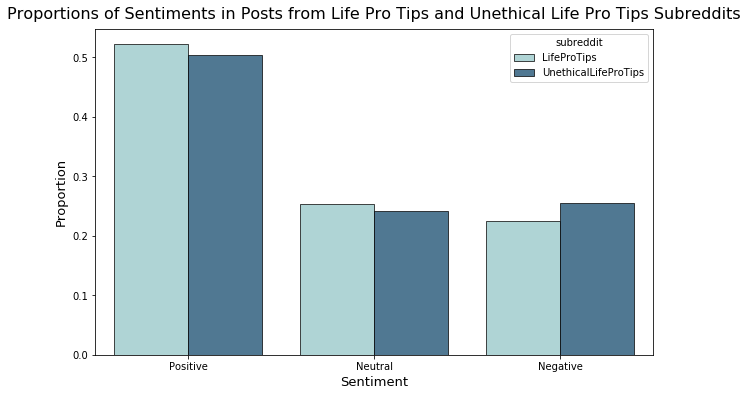

In [79]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x=x, y=y, hue=hue, data=proportions_df, edgecolor = 'black', linewidth = 0.7, palette = [light_blue, medium_blue])
set_labels('Proportions of Sentiments in Posts from Life Pro Tips and Unethical Life Pro Tips Subreddits', 'Sentiment', 'Proportion')

In the graph above and table below, it appears that posts in the Life Pro Tips subreddit might trend to be more positive and less negative than posts in the Unethical Life Pro Tips subreddit, but without error bars, it is hard to tell if this difference is significant.


**Proportion of Posts by Sentiment and Subreddit** 

|Sentiment Category| Life Pro Tips| Unethical Life Pro Tips|
|---|---|---|
|Positive|52.1%|50.5%|
|Neutral|25.3%|24.1%|
|Negative|22.5%|25.3%|

After EDA, I learned that the distributions for post lengths (words and characters) are highly spread out. Although it appears that the posts in Life Pro Tips are longer than those in Unethical Life Pro Tips, the high variability in post lengths must be considered. Additionally, sentiment analysis of the posts revealed that, for both subreddits, the vast majority of posts are neutral or positive. However, looking at counts of each sentiment category revealed that posts in Life Pro Tips might be less negative than posts in Unethical Life Pro Tips.

Additionally, when attempting to correctly classify the posts, EDA informed me that the amount of overlap in words between the two subreddits might prove to be challenging. In the top 500 words per subreddit, only 296 are unique. 

## Model Preparation
**NOTE**: In a preliminary set of models (not shown), I determined that stemmed text and the Tfidf Vectorizer would be a good choice for my data. Therefore, I will conduct a train test split on the stemmed text and set up a Column Transformer to only vectorize my text data.

### Train Test Split

In [80]:
features = ['num_comments', 'score', 'post_length_char', 'post_length_words', 'polarity', 'stemmer_text']
X = subreddits[features]
y = subreddits['is_unethical']

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = RANDOM_STATE, stratify = y)

#### Data for Multinomial Bayes - Only Vectorized Text

In [82]:
X_bayes = subreddits[['stemmer_text']]
y_bayes = subreddits['is_unethical']

In [83]:
X_bayes_train, X_bayes_test, y_bayes_train, y_bayes_test = train_test_split(X_bayes, y_bayes, test_size = 0.3, random_state = RANDOM_STATE, stratify = y)

### Define Stop Words Hyperparameter for Vectorizer

In [84]:
nltk_stopwords = stopwords.words('english') + stopwords.words('spanish')
custom_stop_words = nltk_stopwords + ['someon', 'll', 'like', 'know', 'ulpt', 'lpt', 'need', 'use', 'make', 'wa', 'way', 'peopl', 'ask', 'say', 'time', 'thi', 'want', 'work', 'just', 'start', 'ha', 'tri', 'becaus', 'onli', 'friend']

### Build a Column Transformer to Only Apply Vectorizer to Text Features

In [85]:
tfidf_transformer = ColumnTransformer([
    ('tfidf', TfidfVectorizer(), 'stemmer_text'),], 
    remainder='passthrough')

## Modeling

### Functions

In [86]:
def display_accuracy_scores(model, xtrain, ytrain, xtest, ytest):
    print(f'The cross validation accuracy score is {round(cross_val_score(model, xtrain, ytrain).mean(),4)}.')
    print(f'The training accuracy score is {round(model.score(xtrain, ytrain),4)}.')
    print(f'The testing accuracy score is {round(model.score(xtest, ytest),4)}.')

In [87]:
def display_accuracy_scores_gs(model, xtrain, ytrain, xtest, ytest):
    print(f'The training accuracy score is {round(model.score(xtrain, ytrain),4)}.')
    print(f'The testing accuracy score is {round(model.score(xtest, ytest),4)}.')

In [88]:
def display_cross_val_gs(model):
    print(f'The cross_val score is {round(model.best_score_, 4)}.')

In [89]:
def get_training_sensitivity(actual_values, predicted_values):
    tn, fp, fn, tp = confusion_matrix(actual_values, predicted_values).ravel()
    print(f'The training sensitivity score is {round(tp/(tp+fn), 4)}.')

In [90]:
def get_testing_sensitivity(actual_values, predicted_values):
    tn, fp, fn, tp = confusion_matrix(actual_values, predicted_values).ravel()
    print(f'The testing sensitivity score is {round(tp/(tp+fn), 4)}.')

### Model 1: Null Model

In [91]:
null = DummyClassifier(strategy = 'stratified', random_state = RANDOM_STATE) # Will respect training class distribution

In [92]:
null.fit(X_train, y_train);

In [93]:
#### Evaluate Metric (Accuracy)

In [94]:
display_accuracy_scores(null, X_train, y_train, X_test, y_test)

The cross validation accuracy score is 0.5012.
The training accuracy score is 0.5049.
The testing accuracy score is 0.5043.


The null model is making predicitions in order to preserve the class distributions of the training set. In order to perform better than the null model, any models that are built must perform better than 50% accuracy.

### Model 2a: Logistic Regression with No Regularization

#### Create Pipeline

In [95]:
logreg_pipe = Pipeline([
    ('tfidf', tfidf_transformer),
    ('logreg', LogisticRegression(penalty = 'none', solver = 'newton-cg', max_iter = 600))
])

# The model would not converge for the other solvers. Newton-cg can be used to fit larger datasets.

#### Grid Search Over Pipeline

In [96]:
logreg_pipe_params = {
    'tfidf__tfidf__stop_words': [nltk_stopwords],
    'tfidf__tfidf__ngram_range': [(1,1)],
    'tfidf__tfidf__min_df': [6],
    'tfidf__tfidf__max_df': [0.25],
    'tfidf__tfidf__max_features': [750]
}

# Only best hyperparameters shown

In [97]:
gs_logreg_pipe = GridSearchCV(logreg_pipe, 
                              param_grid = logreg_pipe_params, 
                              cv = 5, 
                              n_jobs = -1)

In [98]:
gs_logreg_pipe.fit(X_train, y_train);

#### Evaluate Metric (Accuracy)

In [99]:
display_cross_val_gs(gs_logreg_pipe)

The cross_val score is 0.7044.


In [100]:
display_accuracy_scores_gs(model = gs_logreg_pipe, xtrain = X_train, xtest = X_test, ytrain = y_train, ytest = y_test)

The training accuracy score is 0.845.
The testing accuracy score is 0.7243.


Although this model performs better than the baseline model (test accuracy = 72.4%), it suffers from slight bias and high variance. Even though I limited features created by the vectorizer to 750, it is likely that this number of features is still too many for this model. If time allows, manual pruning of features based on coefficients could help to improve reduce the high variance in the model.

### Model 2b: Logistic Regression with Regularization

#### Create Pipeline

In [101]:
logreg_reg_pipe = Pipeline([
    ('tfidf', tfidf_transformer),
    ('ss', StandardScaler(with_mean = False)), # Also tried robust scaler
    ('logreg', LogisticRegression(solver = 'liblinear'))])

#### Grid Search Over Pipeline

In [102]:
logreg_reg_pipe_params = {
    'tfidf__tfidf__stop_words': [nltk_stopwords],
    'tfidf__tfidf__ngram_range': [(1,2)],
    'tfidf__tfidf__max_df': [0.25],
    'tfidf__tfidf__min_df': [12],
    'logreg__penalty': ['l2'],
    'logreg__C': [0.0001]
}
# Only best params to minimize overfitting remain in grid

In [103]:
gs_logreg_reg_pipe = GridSearchCV(logreg_reg_pipe, param_grid = logreg_reg_pipe_params, cv = 5, n_jobs = -1)

In [104]:
gs_logreg_reg_pipe.fit(X_train, y_train);

#### Evaluate Metric (Accuracy)

In [105]:
display_cross_val_gs(gs_logreg_reg_pipe)

The cross_val score is 0.7422.


In [106]:
display_accuracy_scores_gs(model = gs_logreg_reg_pipe, xtrain = X_train, xtest = X_test, ytrain = y_train, ytest = y_test)

The training accuracy score is 0.8382.
The testing accuracy score is 0.7601.


Although this model remains slightly overfit to the training data, accuracy improved to ~ 76%. This still seems fairly low, so more models will be explored.

### Model 3: Multinomial Naive Bayes

#### Create Pipe

In [107]:
nb_pipe = Pipeline([
    ('tfidf', tfidf_transformer),
    ('nb', MultinomialNB())
])

#### Grid Search Over Pipe

In [108]:
nb_pipe_params = {
    'tfidf__tfidf__stop_words': [nltk_stopwords],
    'tfidf__tfidf__min_df': [3],
    'tfidf__tfidf__max_df': [0.20],
    'tfidf__tfidf__ngram_range': [(1,2)],
    'tfidf__tfidf__max_features': [None]
}

In [109]:
gs_nb_pipe = GridSearchCV(nb_pipe, param_grid = nb_pipe_params, cv = 5, n_jobs = -1)

In [110]:
gs_nb_pipe.fit(X_bayes_train, y_bayes_train);

#### Evaluate Metric (Accuracy)

In [111]:
display_cross_val_gs(gs_nb_pipe)

The cross_val score is 0.777.


In [112]:
display_accuracy_scores_gs(gs_nb_pipe, X_bayes_train, y_bayes_train, X_bayes_test, y_bayes_test)

The training accuracy score is 0.9016.
The testing accuracy score is 0.7914.


This model also remains overfit to the training data. However, if hyperparameters, such as `min_df`, were adjusted to reduce variance, it also resulted in lower cross_val and testing scores. Therefore, the hyperparameters will be kept as is. The testing accuracy of 79.1% is an imporvement over the previous two models.

### Model 4: KNN

#### Create Pipe

In [113]:
knn_pipe_robust = Pipeline([
    ('tfidf', tfidf_transformer),
    ('rs', RobustScaler(with_centering = False)),
    ('knn', KNeighborsClassifier())
])

# In this case, robust scaler performed better than standard scaler

#### Grid Search Over Pipe

In [114]:
knn_pipe_params = {
    'tfidf__tfidf__stop_words':['english'],
    'tfidf__tfidf__min_df': [8],
    'tfidf__tfidf__max_df': [0.45],
    'tfidf__tfidf__ngram_range': [(1,1)],
    'knn__n_neighbors' : [10],
    'knn__metric':['euclidean'],
    'knn__weights': ['distance']    
}
# Only best params remain

In [115]:
gs_knn_pipe_robust = GridSearchCV(knn_pipe_robust, knn_pipe_params, cv = 5, n_jobs = -1)

In [116]:
gs_knn_pipe_robust.fit(X_train, y_train);

#### Evaluate Metric (Accuracy)

In [117]:
display_cross_val_gs(gs_knn_pipe_robust)

The cross_val score is 0.6425.


In [118]:
display_accuracy_scores_gs(gs_knn_pipe_robust, X_train, y_train, X_test, y_test)

The training accuracy score is 1.0.
The testing accuracy score is 0.6583.


The KNN is one of my worst-performing models. Hyperparameters were adjusted to reduce `max_df` to 0.2, and `neighbors` were reduced to 3, but the training accuracy remained 100%. The high dimensionality of this data and the outliers in some of the numerical features likely do not lend themselves well to this model.

### Model 5: Decision Tree

#### Create Pipeline

In [119]:
dt_pipe = Pipeline([
    ('tfidf', tfidf_transformer),
    ('dt', DecisionTreeClassifier())
])

#### Grid Search Over Pipeline

In [120]:
dt_pipe_params = {
    'tfidf__tfidf__stop_words': ['english'],
    'tfidf__tfidf__min_df': [2],
    'tfidf__tfidf__max_df': [0.6],
    'tfidf__tfidf__ngram_range': [(1,2)],
    'dt__min_samples_split': [7],
    'dt__min_samples_leaf': [1],
    'dt__max_depth': [15]
}
# Only best params to limit overfitting without lowering testing and cross val scores shown

In [121]:
gs_dt_pipe = GridSearchCV(dt_pipe, param_grid = dt_pipe_params, cv = 5, n_jobs = -1)

In [122]:
gs_dt_pipe.fit(X_train, y_train);

#### Evaluate Metrics

In [123]:
display_cross_val_gs(gs_dt_pipe)

The cross_val score is 0.6774.


In [124]:
display_accuracy_scores_gs(gs_dt_pipe, X_train, y_train, X_test, y_test)

The training accuracy score is 0.78.
The testing accuracy score is 0.6896.


The decision tree was also a weak model for this dataset. It was very difficult to balance overfitting without lowering the cross-validation and testing scores. This model ended up performing with 69.1% accuracy. 

### Model 6: Bagging Classifier

#### Create Pipe

In [125]:
bag_pipe = Pipeline([
    ('tfidf', tfidf_transformer),
    ('bc', BaggingClassifier(random_state = RANDOM_STATE))
])

#### Grid Search Over Pipe

In [126]:
bag_pipe_params = {
    'tfidf__tfidf__stop_words':['english'],
    'tfidf__tfidf__min_df': [2],
    'tfidf__tfidf__max_df': [0.3],
    'tfidf__tfidf__ngram_range': [(1,2)],
    'bc__n_estimators':[100]
}

In [127]:
gs_bag_pipe = GridSearchCV(bag_pipe, param_grid = bag_pipe_params, cv = 5, n_jobs = -1)

In [128]:
gs_bag_pipe.fit(X_train, y_train);

#### Evaluate Metric (Accuracy)

In [129]:
display_cross_val_gs(gs_bag_pipe)

The cross_val score is 0.7295.


In [130]:
display_accuracy_scores_gs(gs_bag_pipe, X_train, y_train, X_test, y_test)

The training accuracy score is 1.0.
The testing accuracy score is 0.7521.


The bagging classifier is able to predict posts with 75.2% accuracy, but it is extremely overfit to the training data. Tuning of hyperparameters did not seem to help. In order to reduce overfitting, this might require manual pruning of features.

### Model 7: Random Forest

#### Create Pipe

In [131]:
rf_pipe = Pipeline([
    ('tfidf', tfidf_transformer),
    ('forest', RandomForestClassifier(random_state = 1234))
])

#### Grid Search Over Pipe

In [132]:
rf_pipe_params = {
    'tfidf__tfidf__stop_words' : ['english'],
    'tfidf__tfidf__min_df': [12],
    'tfidf__tfidf__max_df': [0.4],
    'tfidf__tfidf__ngram_range': [(1,2)],
    'forest__criterion': ['entropy'],
    'forest__max_depth': [12],
    'forest__ccp_alpha' : [0.001]
}

In [133]:
gs_rf_pipe = GridSearchCV(rf_pipe, param_grid = rf_pipe_params, cv = 5, n_jobs = -1)

In [134]:
gs_rf_pipe.fit(X_train, y_train);

#### Evaluate Metrics

In [135]:
display_cross_val_gs(gs_rf_pipe)

The cross_val score is 0.7278.


In [136]:
display_accuracy_scores_gs(gs_rf_pipe, X_test, y_test, X_train, y_train)

The training accuracy score is 0.6987.
The testing accuracy score is 0.78.


The random forest appears to be a stronger model for this data set. Both the cross_val score and testing scores were slightly higher than the training score and likely relates to the randommness of the features that were selected for each tree. 

### Model 8: Voting Classifier

In [137]:
voting = VotingClassifier(
    estimators = [
    ('logreg', gs_logreg_reg_pipe),
    ('dt', gs_dt_pipe),
    ('bagging', gs_bag_pipe),
    ('forest', gs_rf_pipe)
])
# Multinomial Bayes not included in vote because of incompatible data (negative values for polarity)

In [138]:
voting.fit(X_train, y_train);

In [139]:
display_accuracy_scores_gs(voting, X_train, y_train, X_test, y_test)

The training accuracy score is 0.9479.
The testing accuracy score is 0.7652.


The voting classifier did not perform as well as I had hoped. It was able to predict posts with 76.5% accuracy. Likely, the models included in the voting classifer were too overfit, and this carried into this ensemble model. To be able to use this more effectively, I think that the vectorized text should be pruned for irrelevant features and the hyperparameters for each model should be re-tuned.

## Model Selection

As shown above, building a classification model to distinguish posts from Life Pro Tips from posts from Unethical Life Pro Tips was a difficult task. Due to the high dimensionality of the text data, several models had a tendency to overfit, and in many cases, reducing the variance of the data also resulted in a reduction in the test and cross-val scores. The accuracy scores for all 9 models are shown below. 

|Model|Train Accuracy|Test Accuracy|
|---|---|---|
|Baseline/Null|0.505|0.501|
|Logistic Regression (No Regularization)|0.845|0.724|
|Logistic Regression with L2 Regularization|0.838|0.760|
|Multinomial Naive Bayes|0.902|0.791|
|KNN (10 Neighbors)|1.0|0.658|
|Decision Tree|0.780|0.691|
|Bagging Classifier|1.0|0.752|
|Random Forest|0.699|0.780|
|Voting Classifier|0.949|0.765|

By just examining the test accuracy, the Baseline model, KNN, and Decision Tree, an Bagging Classifier can immediately be eliminated. However, the other posts also performed in a similar range. Although the ideal model would correctly identify all posts, if all models are performing with similar accuracy, I would also like to look at the sensitivity (true positive rate) for each model. For this particular problem, it should be a priority to minimize the number of Unethical Life Pro Tips that are being classified as normal, ethical Life Pro Tips, and thus, minimizing False Negatives should be a goal. Therefore, the sensitivity will be calculated for Logistic Regression with L2 Regularization, Multinomial Naive Bayes, and the Voting Classifier.

#### Sensitivity Calculations (Results described below.)

In [140]:
print('Logistic Regression with L2:')
get_training_sensitivity(y_train, gs_logreg_reg_pipe.predict(X_train))
get_testing_sensitivity(y_test, gs_logreg_reg_pipe.predict(X_test))

Logistic Regression with L2:
The training sensitivity score is 0.9136.
The testing sensitivity score is 0.8631.


In [141]:
print('Multinomial Naive Bayes:')
get_training_sensitivity(y_bayes_train, gs_nb_pipe.predict(X_bayes_train))
get_testing_sensitivity(y_bayes_test, gs_nb_pipe.predict(X_bayes_test))

Multinomial Naive Bayes:
The training sensitivity score is 0.9521.
The testing sensitivity score is 0.8851.


In [142]:
print('Random Forest:')
get_training_sensitivity(y_train, gs_rf_pipe.predict(X_train))
get_training_sensitivity(y_test, gs_rf_pipe.predict(X_test))

Random Forest:
The training sensitivity score is 0.9615.
The training sensitivity score is 0.906.


In [143]:
print('Voting Classifier:')
get_training_sensitivity(y_train, voting.predict(X_train))
get_testing_sensitivity(y_test, voting.predict(X_test))

Voting Classifier:
The training sensitivity score is 0.9396.
The testing sensitivity score is 0.7471.


#### Discussion of Sensitivity

|Model|Train Accuracy|Test Accuracy|Test Sensitivity|
|---|---|---|---|
|Logistic Regression with L2 Regularization|0.838|0.760|0.863|
|Multinomial Naive Bayes|0.902|0.791|0.885|
|Random Forest|0.699|0.780|0.906|
|Voting Classifier|0.949|0.765|0.745|

As shown in the table above, although accuracy scores for each of these four models were not really high, the Logistic Regression, Multinomial Naive bayes, and the Random Forest did a pretty good job of minimizing the number of Unethical Life Pro Tips that were classifed as ordinary Life Pro Tips. Because it is likely more dangerous for the Unethical Life Pro Tips to be posted to a Life Pro Tips forum, this is good. 

Because the Random Forest can identify all posts with 78% accuracy and has a true positive rate of 90.6%, I will choose this model for further evaluation.

## Model Evaluation

### Confusion Matrix

To better understand the performance of the Random Forest Classifier, I will begin by plotting the confusin matrix for this model.

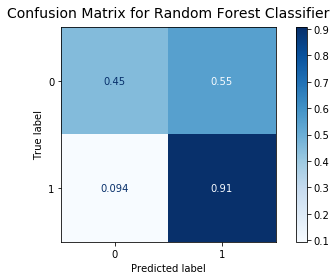

In [144]:
plot_confusion_matrix(gs_rf_pipe, X_test, y_test, normalize = 'true', cmap = 'Blues');
plt.title('Confusion Matrix for Random Forest Classifier', fontdict = {'fontsize':14}, pad = 10)
plt.tight_layout();

The above confusion matrix shows (*clockwise, from upper left corner*) the true negatives, false positives, false negatives, and true positives for the testing predictions generated by the Random Forest Classifier. The data is normalized by row. This plot shows that this model was very good at correctly classifying the Unethical Life Pro Tips posts; it did it with 91% accuracy. However, the model performed around baseline for Life Pro Tips posts, with only 55% accuracy. Although the perfect model would correctly predict both classes equally as well, as previously mentioned, because the Unethical Life Pro Tips subreddit gives advice that is unethical, if accurately classifying one of the classes had to be priortized, I would choose to correctly classify the unethical posts.

### ROC Curve

Text(0.5, 1.0, 'ROC Curve for Random Forest Classifier (AUC = 0.82)')

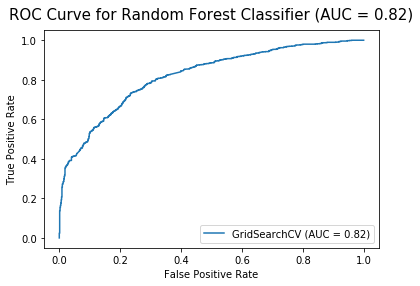

In [145]:
plot_roc_curve(gs_rf_pipe, X_test, y_test);
plt.title('ROC Curve for Random Forest Classifier (AUC = 0.82)', fontdict = {'fontsize':15}, pad = 12)

The ROC Curve shows the performance of the Random Forest Classifier at different thresholds, and the AUC tell us how well our model is able to distinguish between the two classes (Unethical Life Pro Tips and Life Pro Tips) at the various thresholds. A perfect score is 1, and the worst score is 0.5. This model has an AUC of 0.82, so it performs intermediately.

## Model Interpretation

Because the best model was the Random Forest, we are able to view the feature importances for the model. In total, this model had 1374 features (1369 words + 5 numeric). 

### Most Important Features

In [146]:
# Get Word Features
tfidf_feature_names = gs_rf_pipe.best_estimator_.steps[0][1].transformers_[0][1].get_feature_names()

# Combine with Numeric Features
rf_feature_names = ['num_comments', 'score', 'post_length_char', 'post_length_words', 'polarity'] + tfidf_feature_names

# Get Feature Importances
rf_feature_importances = gs_rf_pipe.best_estimator_.steps[1][1].feature_importances_

# Plot Data Frame
feature_importances_df = pd.DataFrame({'Feature':rf_feature_names, 'Importance':rf_feature_importances}).sort_values('Importance', ascending = False)

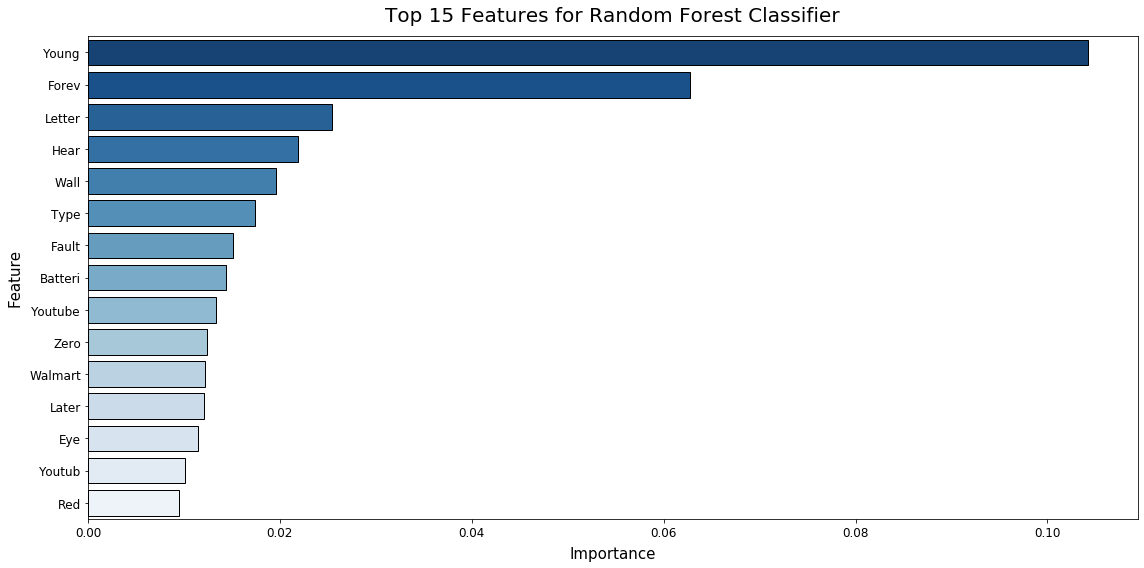

In [147]:
plt.figure(figsize = (16, 8))
sns.barplot(x = feature_importances_df['Importance'][:15], y = feature_importances_df['Feature'].str.title()[:15], orient='h', palette = 'Blues_r', edgecolor = 'black');
plt.title('Top 15 Features for Random Forest Classifier', fontdict = {'fontsize':20}, pad = 15)
plt.xlabel('Importance', fontdict = {'fontsize':15}, labelpad = 7)
plt.ylabel('Feature', fontdict = {'fontsize':15}, labelpad = 7)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.tight_layout();

The above graph shows the top 15 features and their importances. It is important to note that, because the text was preprocessed using Porter stemming,the words appear as stems. 

Of the 15 words that were determined to have the highest feature importances, eight occurred more frequently in the Life Pro Tips corpus. Those words included: "letter", "hear", "wall", "type", "batteri", "later", "eye", "youtub". Many of these words could be related to practical tips, such as "letter", "wall", "type", "batteri", "eye", and "youtub". Seven of the words occurred more frequently in the Unethical Life Pro Tips corpus ("young", "forev", "fault", "youtube", "zero", "walmart", "red"). Out of context, these words do not appear to be overly unethical. One important thing that I notice is that "youtub" and "youtube" are likely mispellings of the same word. To improve the model and reduce dimensionality, spelling errors could be fixed.

### Sentiment Analysis on More Frequent Words by Subreddit

In [181]:
# Divide Words by Where They Appear More

more_lpt = []
more_ulpt = []
equal = []

lpt_df = stemmed_labeled_words_df[stemmed_labeled_words_df['is_unethical'] == 0]
ulpt_df = stemmed_labeled_words_df[stemmed_labeled_words_df['is_unethical'] == 1]

for word in tfidf_feature_names:
    if lpt_df[word].sum() > ulpt_df[word].sum():
        more_lpt.append(word)
    elif ulpt_df[word].sum() > lpt_df[word].sum():
        more_ulpt.append(word)
    else:
        equal.append(word)

In [190]:
lpt_rf_sentiment = TextBlob(' '.join(more_lpt))
lpt_rf_sentiment.polarity

0.06450396825396824

In [191]:
ulpt_rf_sentiment = TextBlob(' '.join(more_ulpt))
ulpt_rf_sentiment.polarity

0.02859549441786284

After the sentiment analysis, it appears that most words in both subreddits were judged to be neutral, especially if it refered to a noun. As a whole, the words found more frequently in the Life Pro Tips category were slighlty less neutral (more positive) than the words found more frequently in the Unethical Life Pro Tips Subreddit.

## Conclusions

For this problem, I was tasked with building a classification model that could accurately distinguish posts from the Life Pro Tips Subreddit from the Unethical Life Pro Tips Subreddit. The best-performing model was a Random Forest Classifier with an accuracy of 78% and a sensitivity of 90.6%. This model is good at accurately predicting posts from the Unethical Life Pro Tips Subreddit, but it performs almost at Baseline at for posts from Life Pro Tips.